Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

**Описание данных**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

<div class="alert alert-warning">
    
  <b>Комментарий ревьюера</b>
    
  ⚠️ Хорошо, что есть описание цели проекта, только не надо копировать из задания с путями к файлам и т.д. Лучше написать своими словами, например: 
- название
- краткое описания проекта
- цели и задачи
- описание исходных данных
- план (декомпозиция) анализа данных 

и др информация.
</div>

<div class="alert alert-block alert-info">

  <b>Комментарий cтудента</b>

  Убрал лишнее.
</div>
<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.2</b>
    
  ✔️ Правильно!  Предзаполнение проекта просто для удобства выполнения, лучше все переписать самостоятельно.
</div>

## Содержание
* [Загрузка данных и подготовка их к анализу](#chapter1)
* [Функции для расчета и анализа LTV, ROI, удержания и конверсии, а также создания профилей пользователей](#chapter2)
* [Исследовательский анализ данных](#chapter3)
* [Анализ маркетинга](#chapter4)
* [Расчет окупаемости](#chapter5)
* [Общие выводы](#chapter6)

In [1]:
import pandas as pd
import numpy as np
import datetime 
from datetime import timedelta

from scipy import stats as st

import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
   

## Загрузка данных и подготовка их к анализу <a class ="anchor" id="chapter1"></a>

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
    
except:
    visits = pd.read_csv('/Users/vadimhlebnikov/Downloads/visits_info_short.csv')
    orders = pd.read_csv('/Users/vadimhlebnikov/Downloads/orders_info_short.csv')
    costs = pd.read_csv('/Users/vadimhlebnikov/Downloads/costs_info_short.csv')

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Отличная загрузка! Так можно работать как локально, так и в окружении Практикума.
</div>

In [3]:
#приведем название столбцов к "змеиному" формату и переведем столбцы со временем в формат datetime 
visits = visits.rename(columns={'User Id': 'user_id', 
                       'Region':'region', 
                       'Device':'device',
                       'Channel':'channel',
                       'Session Start':'session_start',
                       'Session End':'session_end'})

orders = orders.rename(columns={'User Id': 'user_id', 
                       'Event Dt':'event_dt', 
                       'Revenue':'revenue'})

costs.columns = costs.columns.str.lower()

In [4]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [5]:
#Поверка изменения форматов
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [7]:
costs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [8]:
#Проверка на дубликаты (их нет)
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
costs.duplicated().sum()


0

Данные не имеют очевидных проблем. Явные дубликаты отсутствуют. Столбцы, содержащие информацию о времени событий, были переведены в формат datetime. 


<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Данные получены и подготовлены к анализу!  Молодец, что заметил неверный формат даты и поменял.
</div>

Функции для расчета и анализа LTV, ROI, удержания и конверсии, а также создания профилей пользователей <a class ="anchor" id="chapter2"></a>

In [11]:
# Функция для профилей
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [12]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
# Функция расчета конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Отличные функции!
</div>

## Исследовательский анализ данных <a class ="anchor" id="chapter3"></a>

In [19]:
#Составим профиль пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


<div class="alert alert-warning">
    
  <b>Комментарий ревьюера</b>
    
  ⚠️ Не выводи на показ весь датафрейм, при больших объемах можно подвесить ноутбук. Используй head(), tail() или sample().
</div>

<div class="alert alert-block alert-info">

  <b>Комментарий cтудента</b>

  Спасибо, поправил.
</div>
<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.2</b>
    
  ✔️ 👌
</div>

In [20]:
#Минимальная дата привлечения пользователей
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [21]:
#Максимальная дата привлечения пользователей
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Замечательно, у нас есть даты и они даже в рамках 1 года!
</div>

In [22]:
#Расчитаем долю платящих пользвателей по регионам
regions = pd.DataFrame(profiles.groupby('region')['user_id']
                       .nunique().
                       sort_values(ascending=False))
reg_pay = pd.DataFrame(profiles.groupby('region')['payer']
                       .sum().
                       sort_values(ascending=False))
share_table = regions.merge(reg_pay, on=['region'], how='left')

share_table['share'] =  share_table['user_id']/share_table['user_id'].sum()

share_table['share_of_payers'] = share_table['payer']/share_table['user_id']

share_table['share_from_payers'] = share_table['payer']/share_table['payer'].sum()

share_table



,user_id,payer,share,share_of_payers,share_from_payers
region,,,,,
United States,100002,6902,0.666644,0.069019,0.777165
UK,17575,700,0.117160,0.039829,0.078820
France,17450,663,0.116327,0.037994,0.074654
Germany,14981,616,0.099868,0.041119,0.069362


<div class="alert alert-danger">
    
  <b>Комментарий ревьюера</b>
    
  ❌ Странно мы считаем долю платящих.Например для США: делим количество платящих пользователей на общее количество пользователей 6902 / 100002 = 0,069 т.е. 6,9%. 
    
Пересчитай тут и проверь по девайсам с рекламными каналами.
</div>

<div class="alert alert-block alert-info">

  <b>Комментарий cтудента</b>

  Неточно интерпретировал задание. Предположил, что интересует доля платящих по странам от всех платящих. Поправил.
</div>
<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.2</b>
    
  ✔️ С платящими определились! 👍
    
Вывод доли платящих лучше отсортировать по убыванию этой самой доли.
</div>

Доля платящих пльзователй в США значительно выше и составляет почти 7% от числа пользователей из этой страны. В Великобритании, Франции и Германии - около 4%. Если высчитывать доли стран от числа платящих пользователей, то **абсолютным лидером являются США, чья доля составляет почти 80%**.

In [23]:
#Расчитаем долю платящих пользвателей по регионам
devices = pd.DataFrame(profiles.groupby('device')['user_id']
                       .nunique().
                       sort_values(ascending=False))
reg_pay = pd.DataFrame(profiles.groupby('device')['payer']
                       .sum().
                       sort_values(ascending=False))
share_table = devices.merge(reg_pay, on=['device'], how='left')

share_table['share'] =  share_table['user_id']/share_table['user_id'].sum()

share_table['share_of_payers'] = share_table['payer']/share_table['user_id']

share_table['share_from_payers'] = share_table['payer']/share_table['payer'].sum()

share_table

,user_id,payer,share,share_of_payers,share_from_payers
device,,,,,
iPhone,54479,3382,0.363174,0.062079,0.380813
Android,35032,2050,0.233534,0.058518,0.230830
PC,30455,1537,0.203023,0.050468,0.173066
Mac,30042,1912,0.200269,0.063644,0.215291


Больше всего пользователей приложения пользуются iPhone (36%). Доля платящих среди них - 6,2%. **В результате платформа iPhone является лидером в структуре платящих пользователей (38%) и Android (23%)**.

In [24]:
#Расчитаем долю платящих пользвателей по регионам
channels = pd.DataFrame(profiles.groupby('channel')['user_id']
                       .nunique().
                       sort_values(ascending=False))
reg_pay = pd.DataFrame(profiles.groupby('channel')['payer']
                       .sum().
                       sort_values(ascending=False))
share_table = channels.merge(reg_pay, on=['channel'], how='left')

share_table['share'] =  share_table['user_id']/share_table['user_id'].sum()

share_table['share_of_payers'] = share_table['payer']/share_table['user_id']

share_table['share_from_payers'] = share_table['payer']/share_table['payer'].sum()

share_table

,user_id,payer,share,share_of_payers,share_from_payers
channel,,,,,
organic,56439,1160,0.376240,0.020553,0.130616
FaceBoom,29144,3557,0.194283,0.122049,0.400518
TipTop,19561,1878,0.130400,0.096007,0.211463
OppleCreativeMedia,8605,233,0.057364,0.027077,0.026236
LeapBob,8553,262,0.057017,0.030633,0.029501
WahooNetBanner,8553,453,0.057017,0.052964,0.051008
RocketSuperAds,4448,352,0.029652,0.079137,0.039635
MediaTornado,4364,156,0.029092,0.035747,0.017566
YRabbit,4312,165,0.028745,0.038265,0.018579


Более трети пользователей были привлечены в прилоение органически. Но доля платящих пользователей у этого источника всего 2%, поэтому на этот источник приходится всего 13% платящих пользователей. **Из платных каналов привлечения лидируют FaceBoom и TipTop, на которые приходится соответственно 19 и 13% всех пользователей и 40% и 21% платящих пользоваталей**.

## Анализ маркетинга <a class ="anchor" id="chapter4"></a>

In [25]:
#Всего потрачено на привлечени пользователей
print('На привлечение пользователей потрачено', costs['costs'].sum(), 'рублей.')


На привлечение пользователей потрачено 105497.30000000002 рублей.


<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Общие затраты посчитали.
</div>

In [26]:
channel_costs = pd.DataFrame(costs.groupby('channel')['costs'].sum().sort_values(ascending=False))
channel_costs['share'] = channel_costs['costs']/channel_costs['costs'].sum()
channel_costs



,costs,share
channel,,
TipTop,54751.30,0.518983
FaceBoom,32445.60,0.307549
WahooNetBanner,5151.00,0.048826
AdNonSense,3911.25,0.037074
OppleCreativeMedia,2151.25,0.020392
RocketSuperAds,1833.00,0.017375
LeapBob,1797.60,0.017039
lambdaMediaAds,1557.60,0.014764
MediaTornado,954.48,0.009047


<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️  На популярные каналы тратится больше. Здорово, что добавлен процент затрат каждого канала от общей суммы! Видим, что два канала съели более 80% бюджета.

</div> 

In [27]:
time_costs = pd.DataFrame(costs.groupby('dt')['costs'].sum().sort_values(ascending=False))

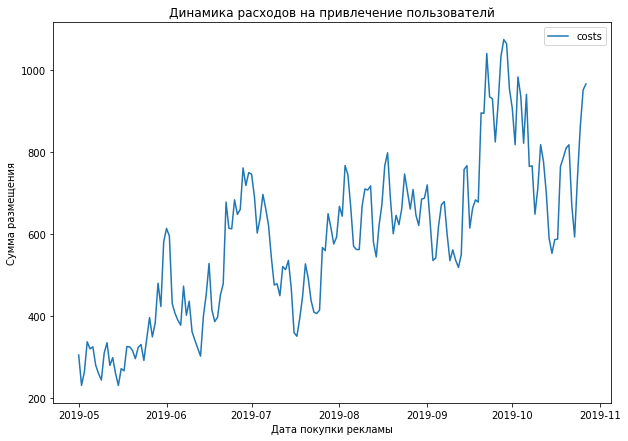

In [28]:
#Строим график расходов на привлечение пользователей
time_costs.plot(figsize=(10,7))
plt.xlabel('Дата покупки рекламы')
plt.ylabel('Сумма размещения')
plt.title('Динамика расходов на привлечение пользователй')
plt.show()


<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Видим динамику расходов.
</div>
<div class="alert alert-danger">
    
  <b>Комментарий ревьюера</b>
    
  ❌ График недооформленный, надо вывести название графика и подписать оси. Чтобы убрать технические надписи вроде:`<AxesSubplot:xlabel='dt'>` в конце вывода графика напиши: `plt.show()`
</div>

<div class="alert alert-block alert-info">

  <b> Комментарий </b>

  Дооформил
</div>
<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.2</b>
    
  ✔️ Хорошо.
</div>

In [29]:
#Доля платящих пользователей в неорганически привлеченном траффике
not_organic_payer_share = profiles.query('channel != "organic" & payer == True')['user_id'].nunique()/profiles.query('channel != "organic"')['user_id'].nunique()
not_organic_payer_share

0.08251664547018778

In [30]:
#Рассчитаем среднюю цену привлечения пользователей по проекту, исключив источник organic.

cost_mean = profiles.query('channel != "organic"')['acquisition_cost'].mean()
cost_mean

1.1274813239427588

In [31]:
cost_per_user= pd.DataFrame(profiles.query('channel != "organic"').groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False))
cost_per_user['dist_from_mean'] = cost_per_user['acquisition_cost'] - cost_mean
cost_per_user

,acquisition_cost,dist_from_mean
channel,,
TipTop,2.799003,1.671522
FaceBoom,1.113286,-0.014196
AdNonSense,1.008054,-0.119427
lambdaMediaAds,0.724802,-0.402679
WahooNetBanner,0.602245,-0.525236
RocketSuperAds,0.412095,-0.715386
OppleCreativeMedia,0.250000,-0.877481
YRabbit,0.218975,-0.908506
MediaTornado,0.218717,-0.908765


In [32]:
#Справочно расчитаем стоимость привлечения платящего пользователя 
cost_per_paying_mean = profiles.query('channel != "organic" & payer == True')['acquisition_cost'].mean()
cost_per_paying_mean

1.3474692632010883

In [33]:
cost_per_paying_user= pd.DataFrame(profiles.query('channel != "organic" & payer == True').groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False))
cost_per_paying_user['dist_from_mean'] = cost_per_paying_user['acquisition_cost'] - cost_per_paying_mean
cost_per_paying_user

,acquisition_cost,dist_from_mean
channel,,
TipTop,2.785961,1.438492
FaceBoom,1.113243,-0.234226
AdNonSense,1.011119,-0.336350
lambdaMediaAds,0.735322,-0.612147
WahooNetBanner,0.600576,-0.746893
RocketSuperAds,0.418493,-0.928977
OppleCreativeMedia,0.250456,-1.097013
MediaTornado,0.217389,-1.130081
YRabbit,0.211338,-1.136131


На привлечение пользователей было потрачено более 105 тыс. рублей. **Основная доля бюджета ушла на две площадки - TipTop (	54,8 тыс. долларов или 52% бюджета и FaceBoom (32,5 тыс. долларов или 31% бюджета)**. Расходы на продвижение динамично возрастали на протяжении всего исследуемого периода (с мая по ноябрь 2019 года). Средняя стоимость привлечения составила 1,12 рубля. Самым дорогим источником пользователей является TipTop с ценой привлечений 2,8 рубля, что выше средней стоимости привлечения на проекту более чем вдвое. Привлечение по остальным источникам дешевле средней по проекту. **Доля платящих пользователей в привлеченном неорганическом траффике составляет 8,3%**.

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ И обходятся популярные каналы дороже.

</div> 

## Расчет окупаемости рекламы <a class ="anchor" id="chapter5"></a>

In [34]:
#Расчитаем LTV и ROI  

horizon_days = 14

observation_date = datetime.datetime(2019, 11, 1).date()

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days
)


<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Правильно, что убираем из расчетов  пользователей с органическим трафиком, ведь мы за них ничего не платим.
</div>

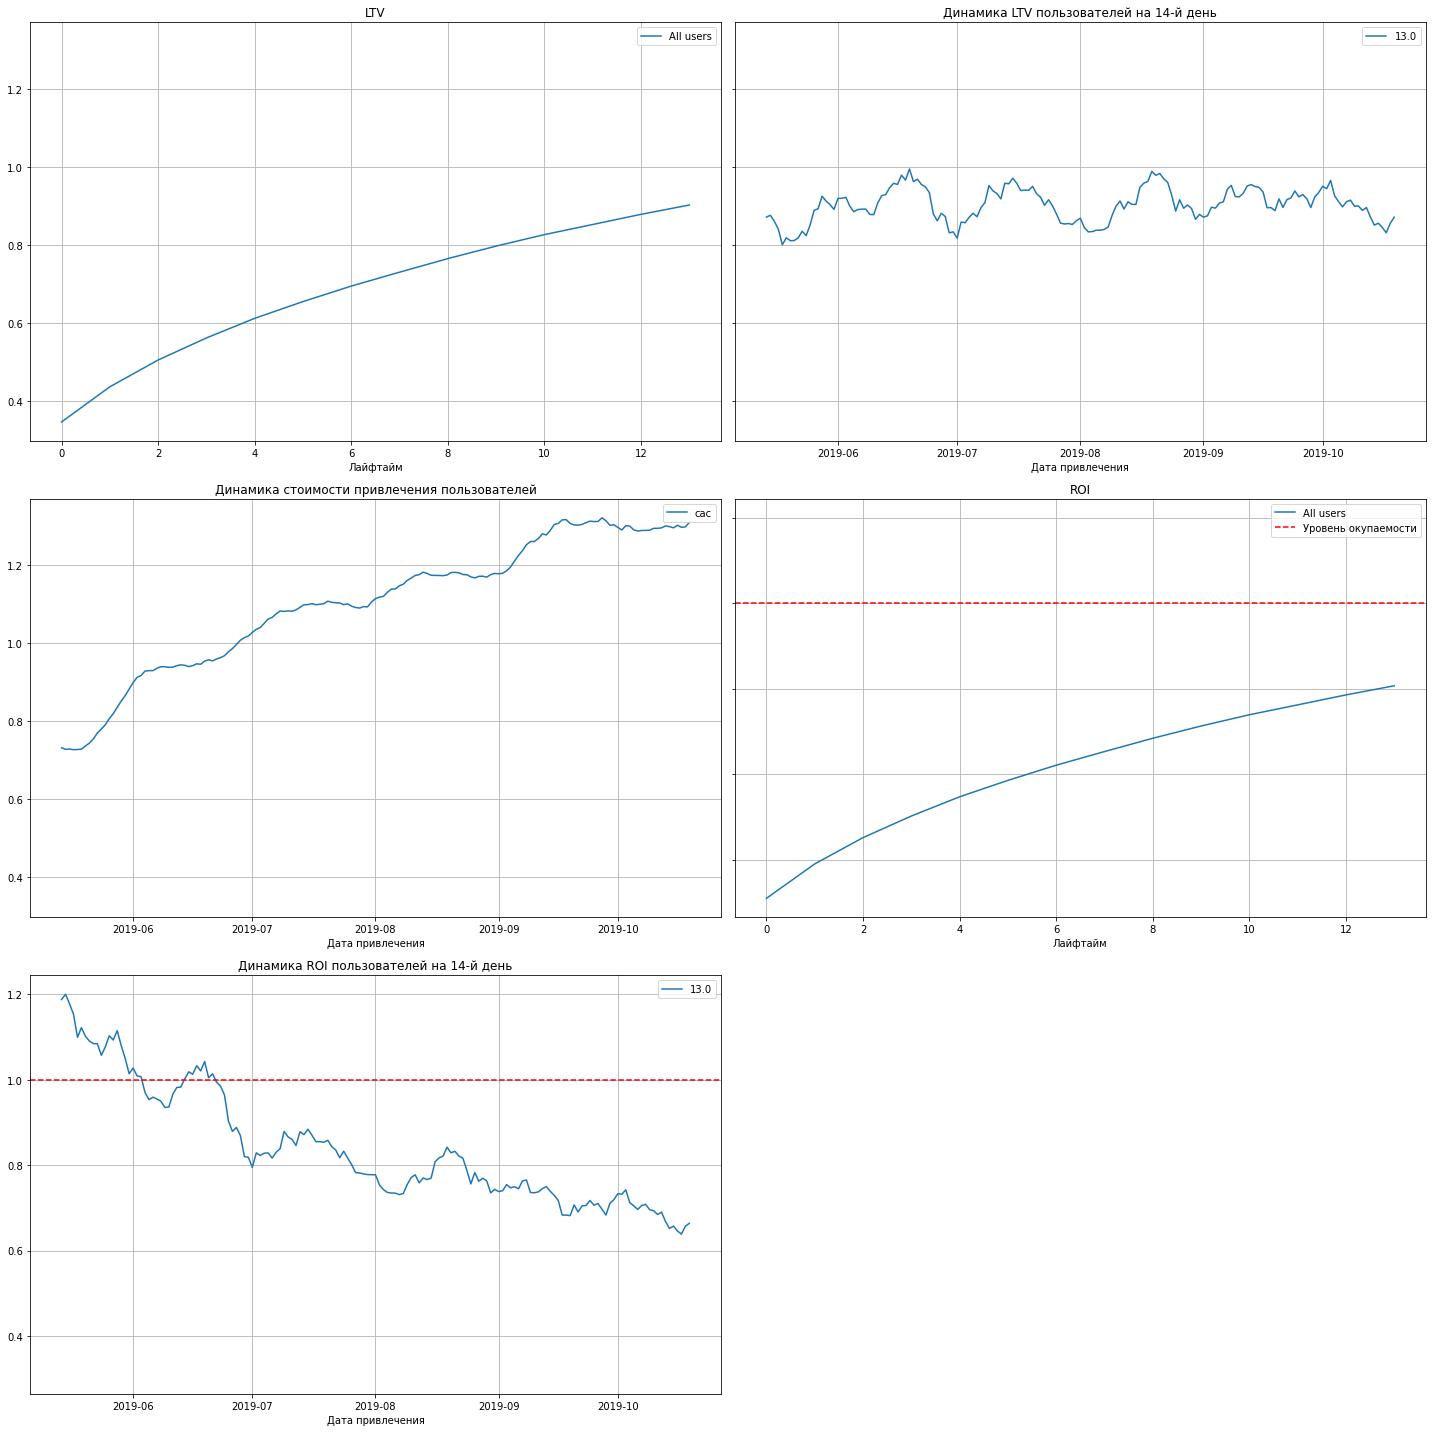

In [35]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days,window=14)

**В целом реклама на 14 день "жизни" клиента не окупается**. При этом LTV примерно стабилен с начала проекта. Окупаемость в первые недели запуска проекта была в положительной зоне, а потом начала резко снижаться **на фоне быстрого роста стоимости платного привлечения аудитории**. Поэтому обратим внимание на каналы привлечения траффика.

<div class="alert alert-warning">
    
  <b>Комментарий ревьюера</b>
    
  ⚠️  Стоит сказать про динамику стоимости привлечения, это у нас основная проблема.
</div>

<div class="alert alert-block alert-info">

  <b> Комментарий </b>

  Добавил
</div>
<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.2</b>
    
  ✔️  👍
    

</div>

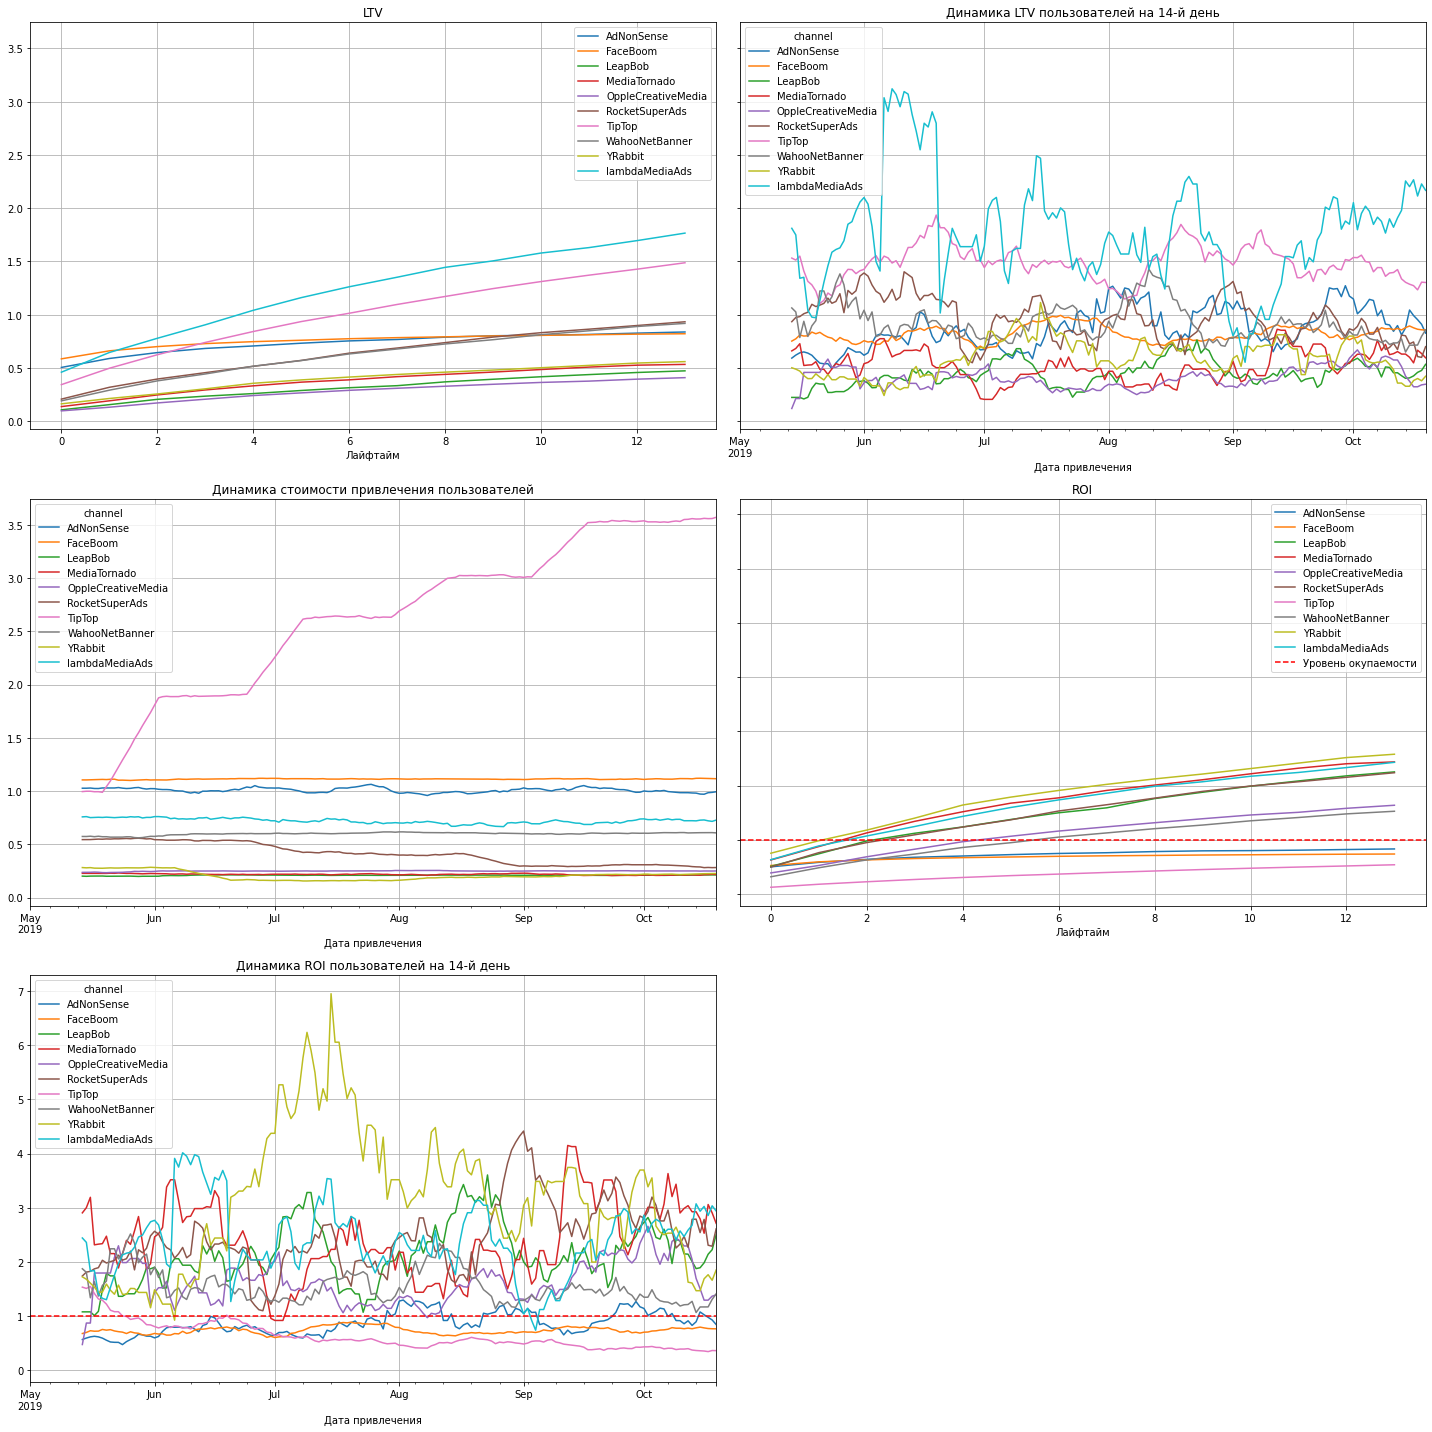

In [36]:
#Строим расчеты LTV и ROI по каналам привлечения траффика 

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Очевиден резкий рост стоимости привлечения пользователей через площадку TipTop.

<div class="alert alert-warning">
    
  <b>Комментарий ревьюера</b>
    
  ⚠️  Тут лучше перечислить все не окупающиеся каналы, их у нас всего 3.
</div>

In [37]:
#Выделим каналы с "положительным" ROI.
roi_grouped[['cohort_size', 'cac', 13.0]].rename(columns={13.0:'roi'}).query('roi > 1').sort_values('roi',ascending = False)

,cohort_size,cac,roi
channel,,,
YRabbit,4102,0.217087,2.578086
MediaTornado,4167,0.219035,2.436519
lambdaMediaAds,2056,0.727237,2.428712
LeapBob,8103,0.210000,2.252399
RocketSuperAds,4251,0.417431,2.237019
OppleCreativeMedia,8139,0.249908,1.637075
WahooNetBanner,8082,0.601856,1.526304


In [38]:
#Выделим каналы с "убыточным" ROI.
bad_channels = roi_grouped[['cohort_size', 'cac', 13.0]].rename(columns={13.0:'roi'}).query('roi < 1')
bad_channels

,cohort_size,cac,roi
channel,,,
AdNonSense,3702,1.008023,0.831337
FaceBoom,27544,1.113419,0.737790
TipTop,18498,2.757774,0.539532


**Не окупаются такие каналы продвижения как TipTop, FaceBoom и AdNonSense**.

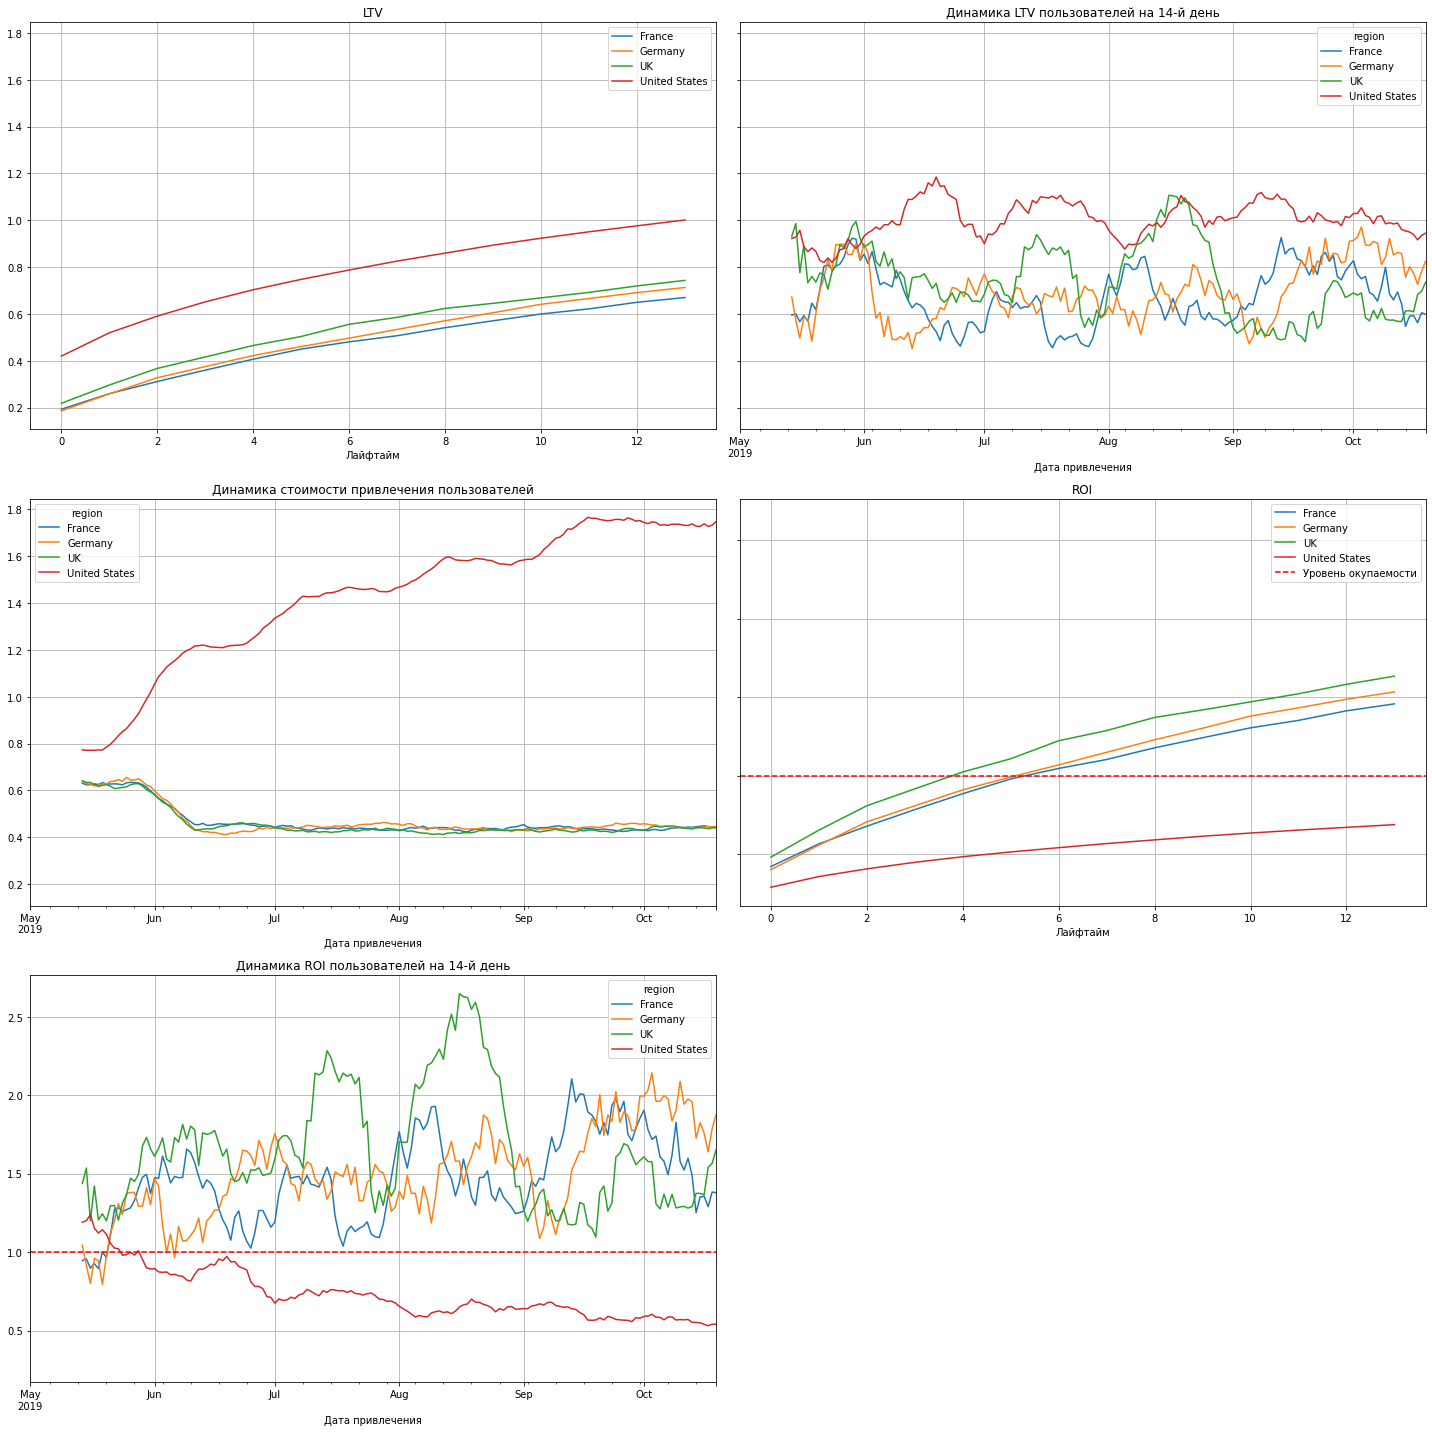

In [39]:
#Строим расчеты LTV и ROI по странам пользователей 
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Можно констатировать значительную разницу в LTV и стоимости привлечения пользователей между США и остальными рынками. При этом разница в LTV значительно меньше разницы в стоимости привлечения. Вероятно, поэтому США является единственным нерентабельным рынком на 14 день.

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Согласен, в США явные проблемы.
</div>

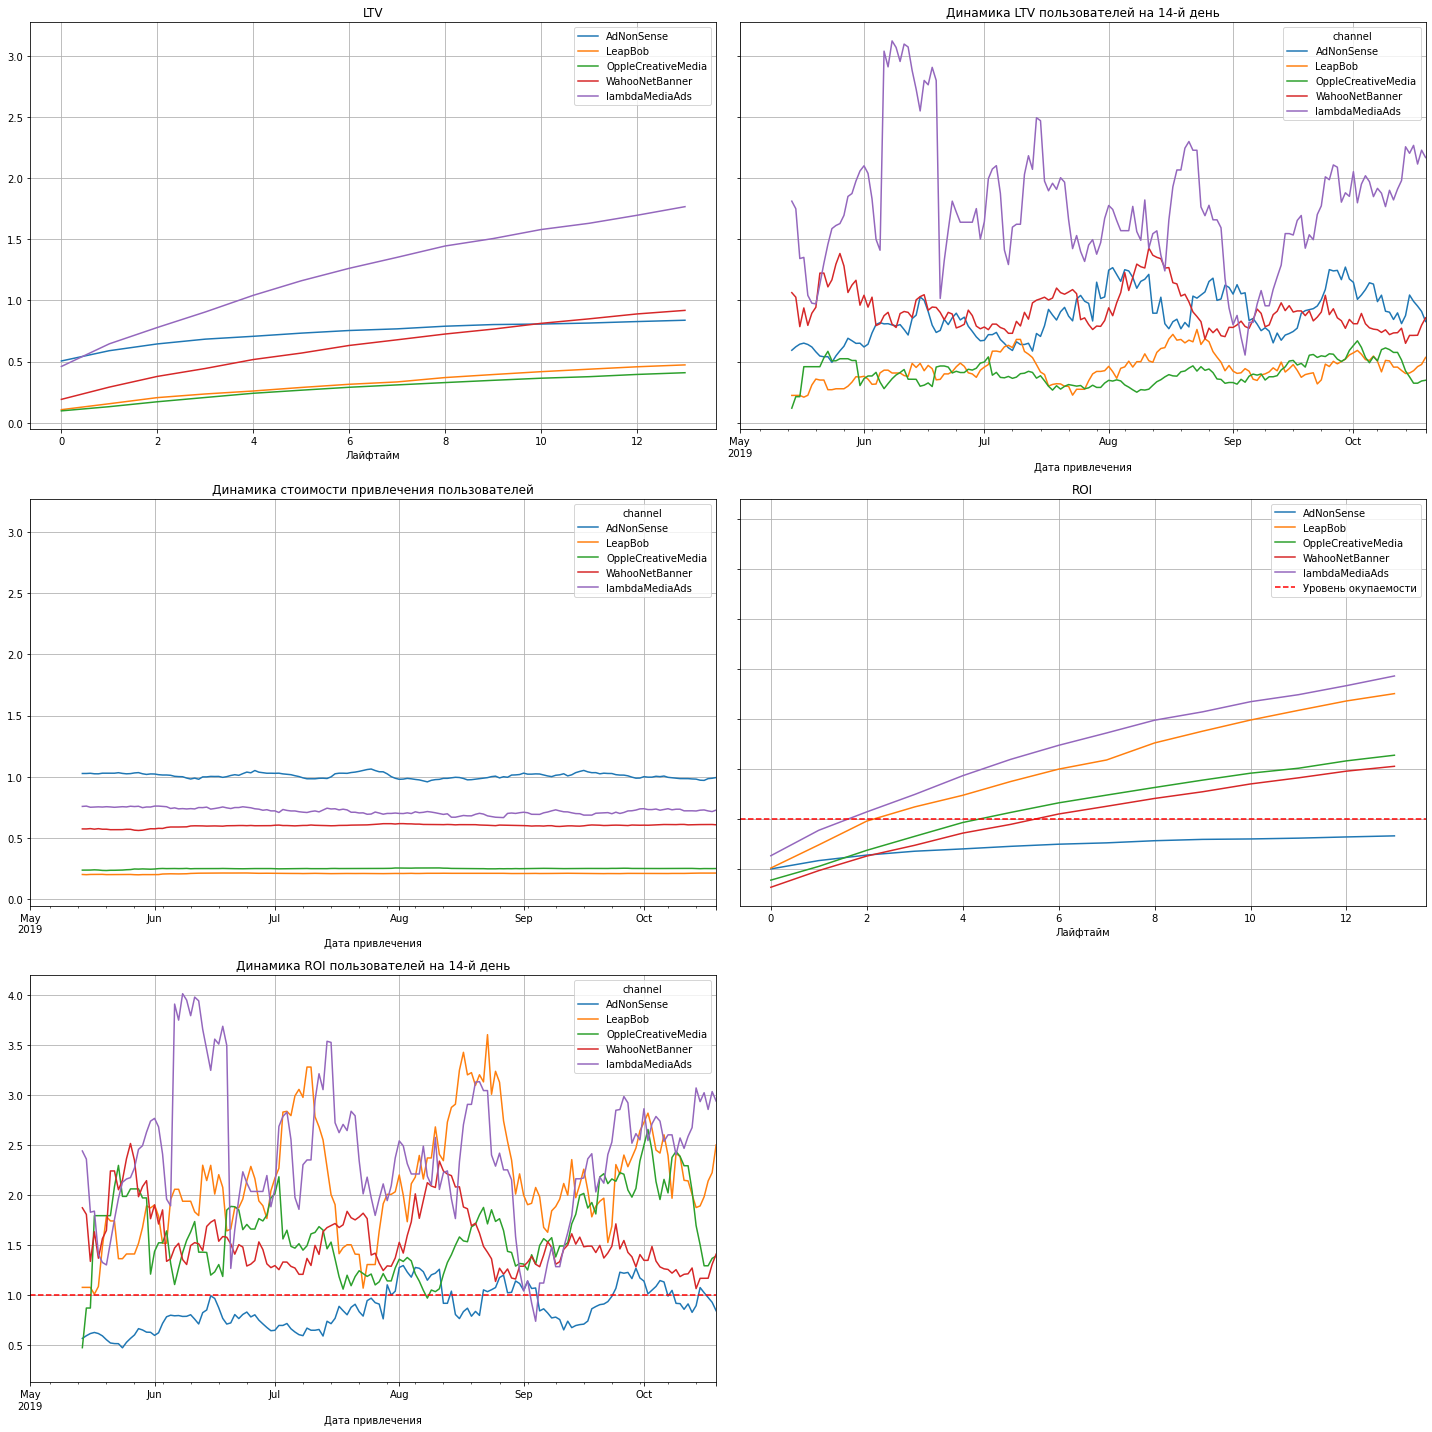

In [40]:
# Аналогичные расчеты без американского рынка
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic" & region != "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

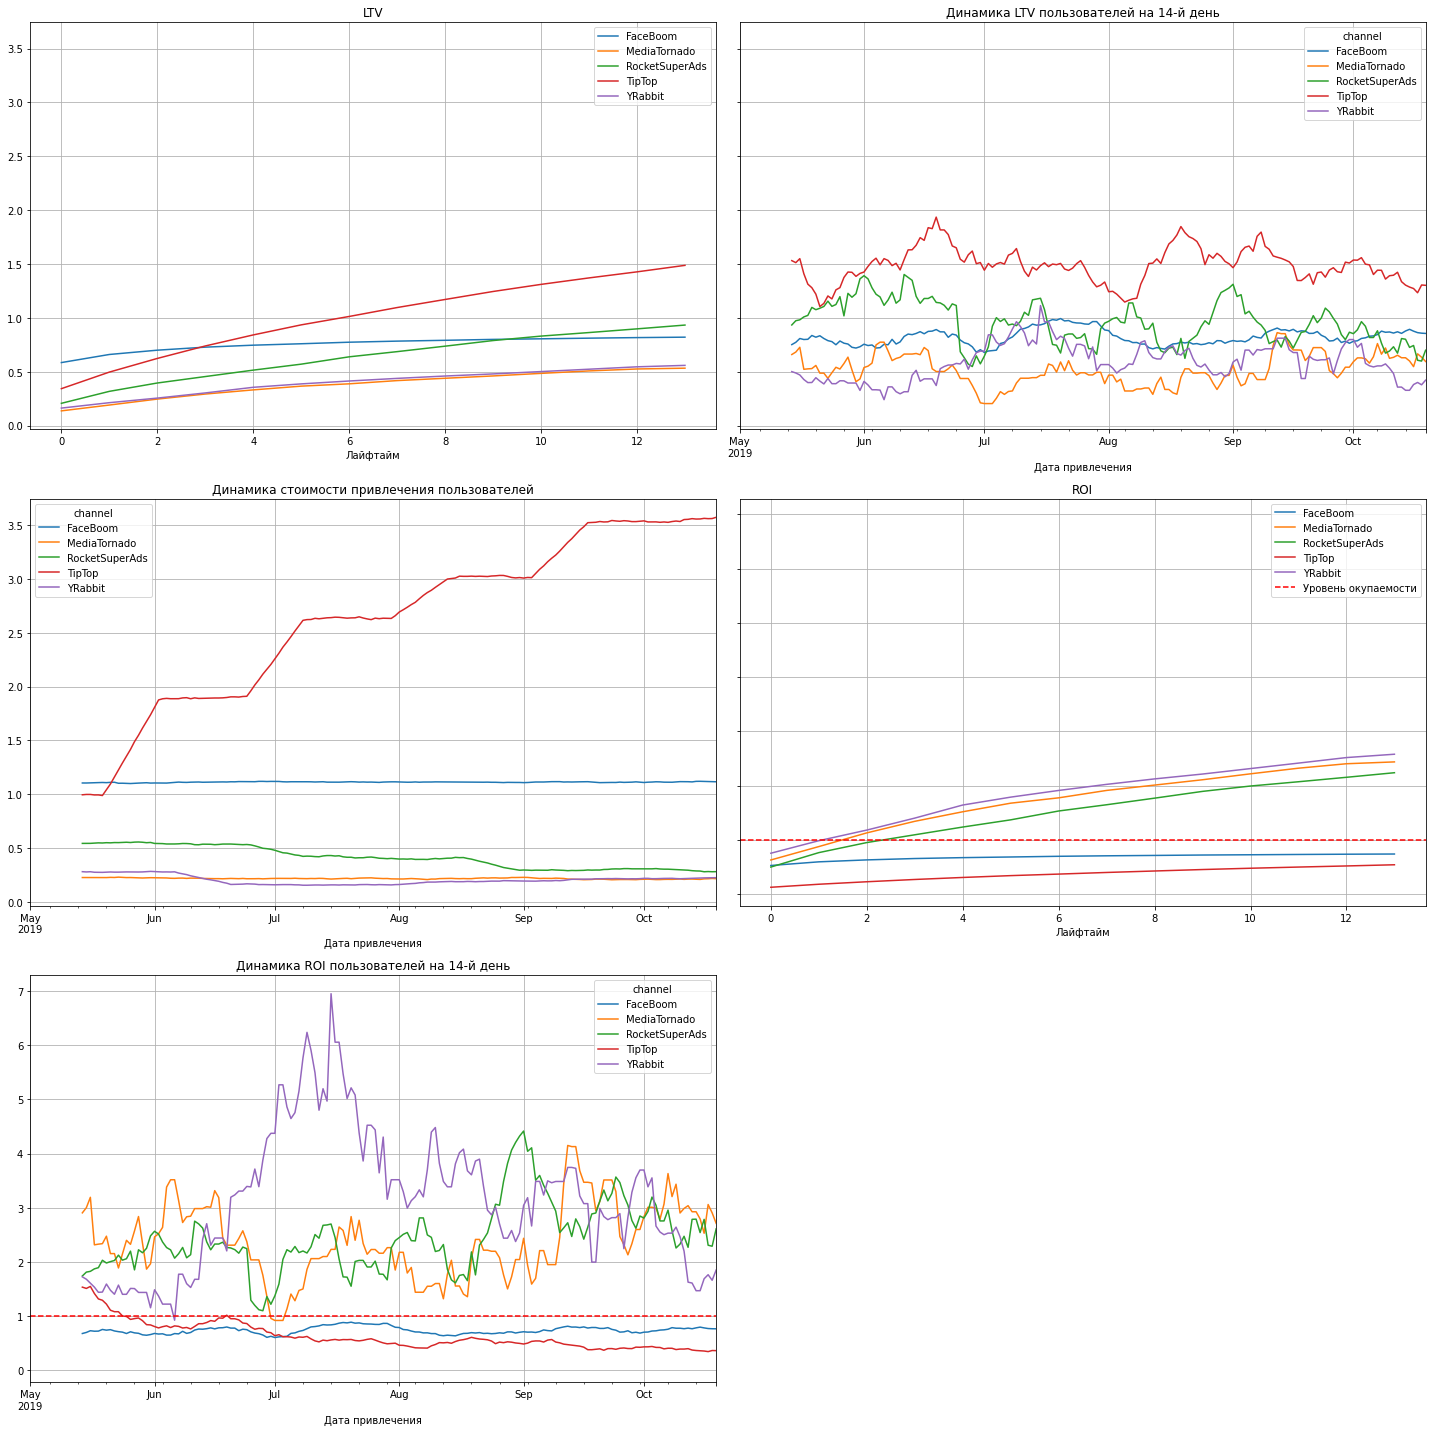

In [41]:
#Только американский рынок
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic" & region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

**Основной причиной убыточности бизнеса в последние месяцы работы Procrastinate Pro+ является резкий рост неокупаемых расходов на рекламу в США**. Это действительно рынок с самым высоким LTV, но при этом стоимость привлечения пользователей на нем в разы больше, чем на других рынках. Поэтому возврат вложенных в маркетинг инвестиций (ROI) на этом рынке значительно меньше единицы. **Бизнес во Франции, Великобритании и Германии стабильно рентабелен и ROI на 14 день стабильно находится в зоне более 1 в данных странах**. Первоначально он был рентабелен и в США, но с резким ростом стоимости привлечения пользователей на 
этом рынке ROI ушел в зону менее 1. Тяжесть положения объясняется в том числе и тем, что на США приходится две трети пользователей приложения, зарегистрировавшиеся в рассматриваемом периоде. 

Рост расходов на привлечение клиентов в США пропорционален росту расходов на продвижение через площадку TipTop, которая оказалась худшей по показателю ROI (0,54). Также не окупились инвестиции в продвижение через FaceBoom, где CAC значительно превышали LTV, а ROI оказался равен 0,74. TipTop и FaceBoom - было основными площадками для продвижения приложения. И они использовались именно на американском рынке. На других рынках 4 из 5 площадок показали ROI выше единицы. Ошибка менеджмента была в приобретении рекламы на слишком дорогих площадках с прицелом на американский рынок. 

**Рекомендации. Усилить продвижение приложения за пределами США по каналам LambdaMediaAds и LeapBob. В США отказаться от продвижения через FaceBoom и TipTop. Лучший ROI на этом рынке дают YRabbit и MediaTornado. Обратить внимание на кампанию на YRabbit в середине июня, она давала в США максимальный ROI**.

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Здорово, что изучена  реклама отдельно по США и Европе! 🔥 
</div>

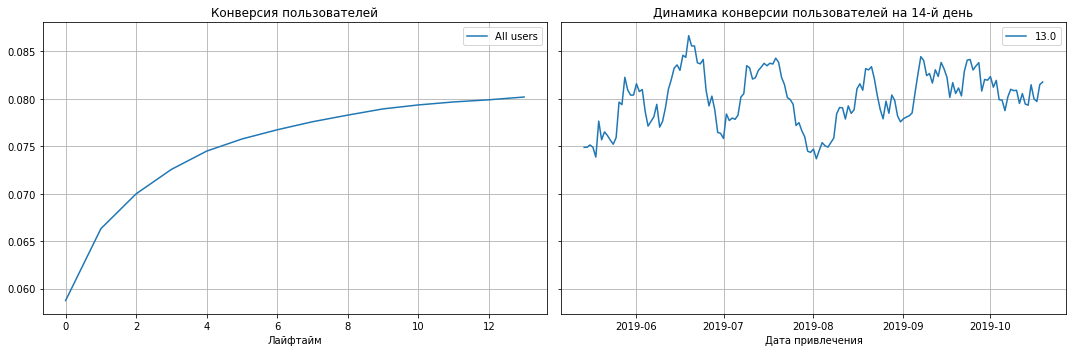

In [42]:
#Строим общую конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'),
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

<div class="alert alert-danger">
    
  <b>Комментарий ревьюера</b>
    
  ❌ Тут есть один недочет, который немного искажает общие данные: из расчетов конверсии и удержания нам так-же следует исключить пользователей с органическим трафиком, поскольку мы за них ничего не платим. 
```python
profiles = profiles.query('channel != "organic"')
```
</div>

<div class="alert alert-block alert-info">

  <b> Комментарий </b>

  Спасибо. Здесь увлекся и забыл отрезать органику.
</div>
<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.2</b>
    
  ✔️  "бесплатные" пользователи сильно искажают показатели. Поэтому их надо обязательно убирать.
</div>

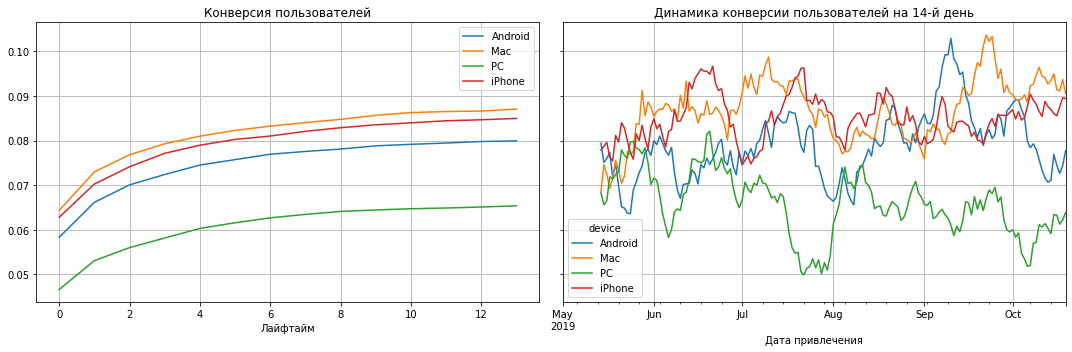

In [43]:
#Строим конверсию в разрезе устройств
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'),
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

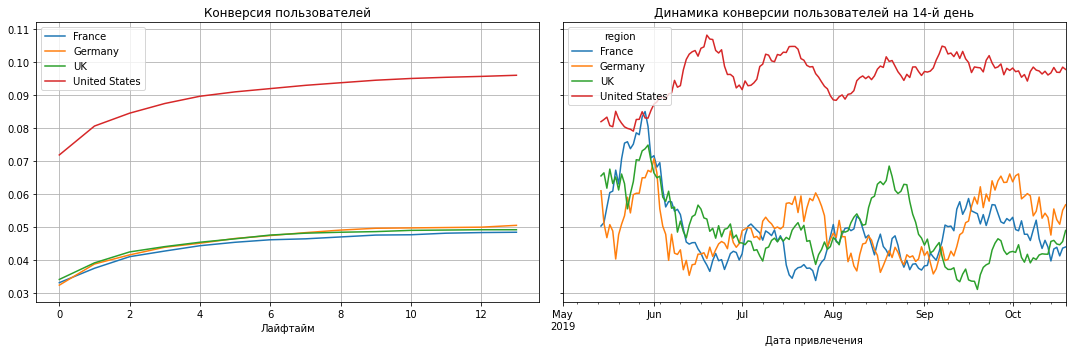

In [44]:
#Строим конверсию в разрезе стран
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'),
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

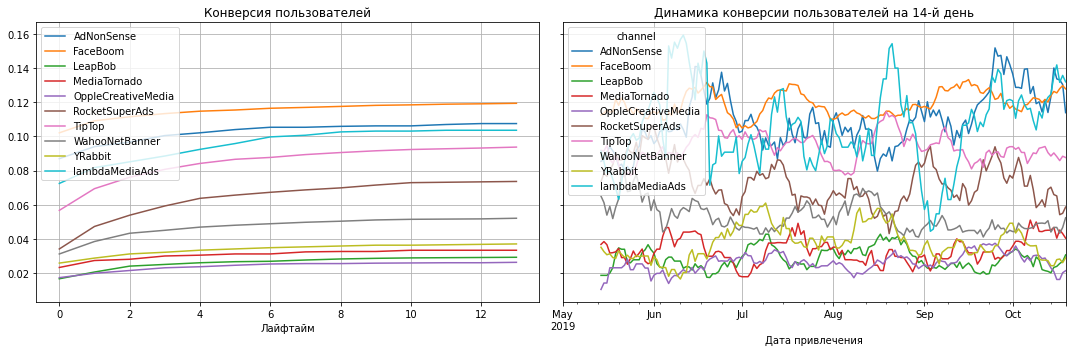

In [45]:
#Строим конверсию в разрезе каналов привлечения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'),
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

Конверсия по устройствам отличается незначительно за исключением PC, где она значительно слабее. **По странам с большим отрывом лидируют пользователи из США**, а по каналам привлечения FaceBoom, AdNonSense, и lambdaMediaAds и TipTop.

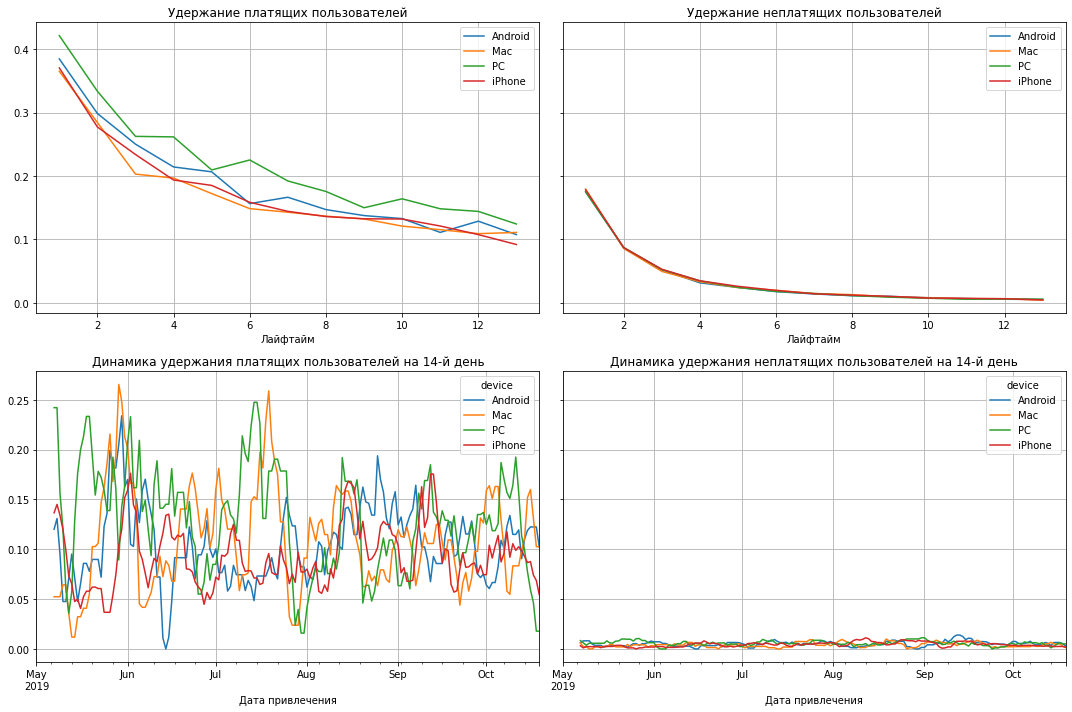

In [46]:
# Строим графики удержания по устройствам

dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days)

 

По усторйствам фиксируется слабая разница в динамике удержания. 

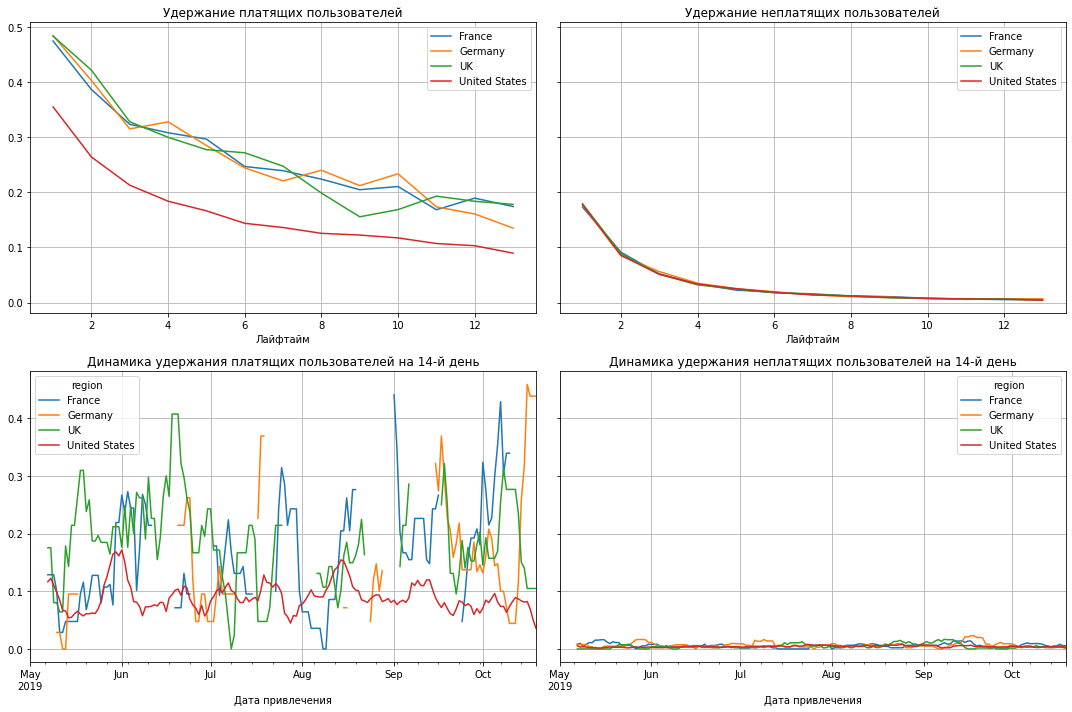

In [47]:
# Строим графики удержания по странам
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days)


Пользователи из США демонстрируют значительно более плохую динамику удержания. Разница между остальными странами незначительна. 

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Еще одну проблему в США обнаружили.
</div>

In [48]:
retention_grouped[['cohort_size', 13.0]].rename(columns={13.0:'retention_14'}).sort_values('retention_14',ascending = False)

cohort_size  retention_14
payer region                                  
True  UK                     534      0.177903
      France                 523      0.173996
      Germany                467      0.134904
      United States         5786      0.089526
False Germany               8563      0.006540
      France                9993      0.005504
      UK                   10002      0.004499
      United States        52776      0.004301

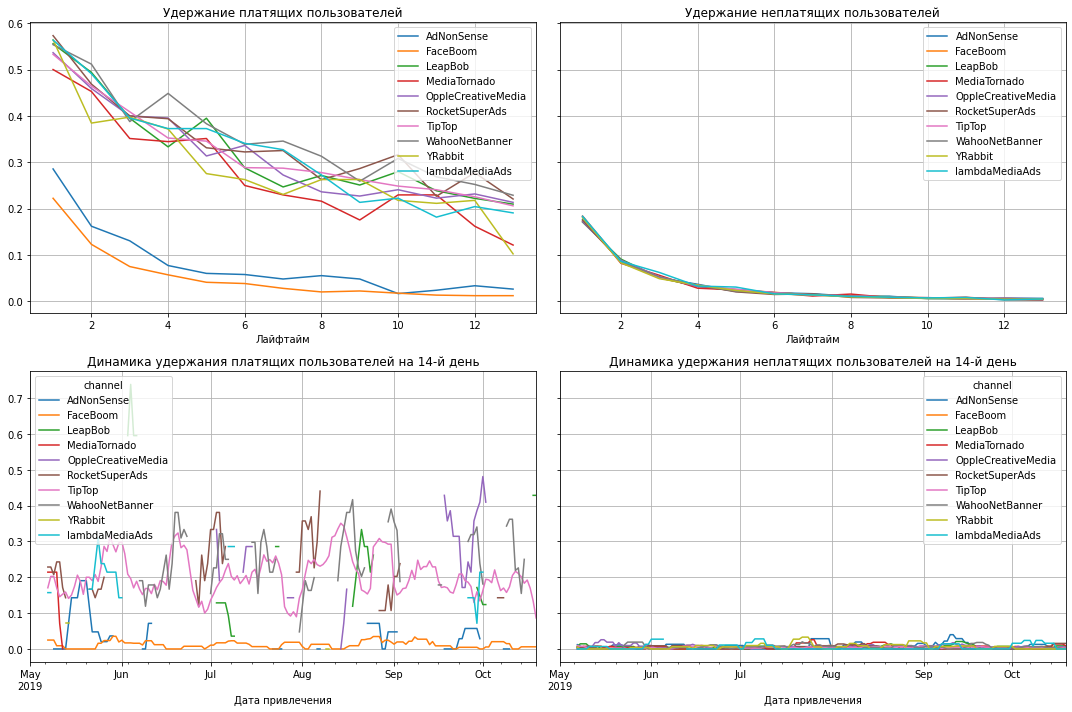

In [49]:
# Строим графики удержания по каналам привлечения
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days)

У FaceBoom, на который сделал ставку маркетинг, самый низкий показатель удержания среди платящих пользователей. Также плохое удержание у AdNonSense. У TipTop - средний показатель.

<div class="alert alert-warning">
    
  <b>Комментарий ревьюера</b>
    
  ⚠️ Плохим удержанием выделяются 2 канала, лучше назвать оба.
</div>

<div class="alert alert-block alert-info">

  <b> Комментарий </b>

  Добавил.
</div>

In [50]:
#ранжируем удержание по источникам 
retention_channel = (retention_grouped[['cohort_size', 13.0]]
                    .rename(columns={13.0:'retention_14'})
                    .sort_values('retention_14',ascending = False))
retention_channel                     

cohort_size  retention_14
payer channel                                      
True  WahooNetBanner              428      0.228972
      RocketSuperAds              335      0.220896
      OppleCreativeMedia          220      0.213636
      LeapBob                     243      0.209877
      TipTop                     1785      0.206162
      lambdaMediaAds              220      0.190909
      MediaTornado                148      0.121622
      YRabbit                     156      0.102564
      AdNonSense                  413      0.026634
      FaceBoom                   3362      0.012493
False AdNonSense                 3289      0.006689
      OppleCreativeMedia         7919      0.005683
      lambdaMediaAds             1836      0.005447
      WahooNetBanner             7654      0.005357
      YRabbit                    3946      0.005068
      MediaTornado               4019      0.004976
      LeapBob                    7860      0.004835
      FaceBoom                  24182      0.004342
      TipTop                    16713      0.004248
      RocketSuperAds             3916      0.002809

Удержание платящих пользователей слабо отличается в зависимости от устройств (небольшое преимущество есть у PC), но в разрезе стран плохим результатом выделяется США (0,1 против 0,2 во Франции и Великобритании). Таким образом низким удержанием клиентов из США нивелируется высокая конверсия по этой страны (вдвое лучше, чем по остальным рынкам - 0,095 и около 0,05). По каналам привлечения самое плохое удержание у FaceBoom (0,012), самого дорого источника привлечения траффика - TipTop, - среднее удержание. 

## Общие выводы <a class ="anchor" id="chapter6"></a>

1. Данные не имеют очевидных проблем. Явные дубликаты отсутствуют. Столбцы, содержащие информацию о времени событий, были переведены в формат datetime.


2. Доля платящих пльзователй в США значительно выше и составляет почти 7% от числа пользователей из этой страны. В Великобритании, Франции и Германии - около 4%. **Если высчитывать доли стран от числа платящих пользователей, то абсолютным лидером являются США, чья доля составляет почти 80%**. 

Платящие пользователи заходят в приложение с четырех видов устройств: iPhone, Android, Mac и PC. Лидерами по числу заходов являются мобильные платформы iPhone (38%) и Android (23%).


3. **В целом реклама на 14 день "жизни" клиента не окупается**. При этом LTV примерно стабилен с начала проекта. Окупаемость в первые недели запуска проекта была в положительной зоне, а потом начала резко падать. 


На привлечение пользователей было потрачено более 105 тыс. рублей. Основная доля бюджета ушла на две площадки - TipTop (54,8 тыс. рублей или 52% бюджета и FaceBoom (32,5 тыс. рублей или 31% бюджета). Расходы на продвижение динамично возрастали на протяжении всего исследуемого периода (с мая по ноябрь 2019 года). **Средняя стоимость привлечения составила 1,12 рубля**. 


**Самым дорогим источником пользователей является TipTop с ценой привлечения 2,8 рубля, что выше средней стоимости привлечения на проекту более чем вдвое**. Привлечение по остальным источникам дешевле средней по проекту. **Доля платящих пользователей в привлеченном неорганическом трафике составляет 8,3%**.


4. **Выявлена значительная разница в LTV и стоимости и привлечения пользователей между США и остальными рынками**. При этом разница в LTV значительно меньше разницы в стоимости привлечения. По LTV  - около 20%, а по CAC - в 4,5 раза. Вероятно, поэтому США является единственным нерентабельным рынком на 14 день.


5. **Основной причиной убыточности бизнеса в последние месяцы работы Procrastinate Pro+ является резкий рост неокупаемых расходов на рекламу в США**. Это действительно рынок с самым высоким LTV, но стоимость привлечения пользователей на нем в разы больше, чем на других рынках. Поэтому возврат вложенных в маркетинг инвестиций (ROI) на этом рынке значительно меньше единицы. Бизнес во Франции, Великобритании и Германии стабильно рентабелен и ROI на 14 день  находится в зоне выше единицы в данных странах. 
 
 
6. **Рост расходов на привлечение клиентов в США пропорционален росту расходов на продвижение через площадку TipTop, которая оказалась худшей по показателю ROI (0,54)**. Также не окупились инвестиции в продвижение через FaceBoom, где CAC значительно превышали LTV, а ROI оказался равен 0,74. TipTop и FaceBoom - были основными площадками для продвижения приложения. 


7. Удержание платящих пользователей слабо отличается в зависимости от устройств (небольшое преимущество есть у PC), но в разрезе стран сравнительно плохой конверсийей выделяется США (0,1 против 0,2 во Франции и Великобритании). **У FaceBoom, на который сделал ставку маркетинг, самый низкий показатель удержания среди платящих пользователей. У TipTop среднее удержание при очень высокой стоимости привлечения**. 
 
 
8. **Рекомендуем усилить продвижение приложения за пределами США по каналам LambdaMediaAds и LeapBob. В США отказаться от продвижения через FaceBoom и TipTop. Лучший ROI на этом рынке дают YRabbit и MediaTornado. Также обратить внимание на рекламную кампанию на YRabbit в середине июня, так как она давала в США максимальный ROI**.

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Отличные общие выводы и рекомендации! Маркетологи оценят! 🙂
</div>

<div style="border:solid black 2px; padding: 20px">
     
  <b>Чек-лист доработок</b>
    
  📃 Добавить краткое описание проекта своими словами.

  📃 Проверить таблицы, отображающие количество пользователей и долю платящих пользователей из каждой страны\устройства\канала.
    
  📃 Дооформить графики, вывести название графика и подписать оси.
    
  📃 Убрать канал "organic" из расчета CAC и анализа конверсии и удержания пользователей.
    
  
Жду твой проект на повторное ревью. Не стесняйся оставлять комментарии и задавать вопросы. Удачи! Все получится.
</div>